**Text Features**

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import umap 
from sklearn.manifold import  TSNE

C:\Users\user\anaconda3\envs\computervision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**(a) Cluster the text features. Can you find meaningful clusters?**



**(b)Design a labeling function for classes dog and cat. Do the annotations labeled as dog or cat sounds form tight clusters in the text and audio feature space?**

**Dimensionality reduction**

In [109]:
an_df = pd.read_csv(r"C:\Users\user\Desktop\MLPC\annotations.csv")
an_df.head()

,task_id,filename,annotator,text,onset,offset,filename_unsafe
0,161977861,560761.mp3,5945971035380930099053858595454362549806990533...,bird twitters nearby with a high pitch two times,16.552368,17.271435,560761_tufted titmouse calling.mp3
1,161987165,240538.mp3,4916274343929406460752597829190197300566135449...,A cow bell clinging repeatedly,12.265866,15.420303,240538_AMB - Cowbell stable Stereowav.mp3
2,161989998,660337.mp3,8960534646813062318784592632173589349806817458...,A child speaks with a high-pitched voice,12.493984,13.315680,660337_Aeroplane Takeoff From Cabinwav.mp3
3,161978339,725686.mp3,4540509031938851510799116530500792274849113758...,A high pitch meowing coming from a cat,16.018221,16.991704,725686_Black Cat Talking.mp3
4,161985729,97606.mp3,1085174475307080254018414698413953957857995126...,An extremely loud brushing sound on a construc...,0.000000,1.626352,97606_jackhammer med distwav.mp3


In [110]:
an_em = np.load(r"C:\Users\user\Desktop\MLPC\annotations_text_embeddings.npz")["embeddings"]

**Clustering Text Features**

In [40]:
kmeans = KMeans(25)
an_df["cluster"] = kmeans.fit_predict(an_em)

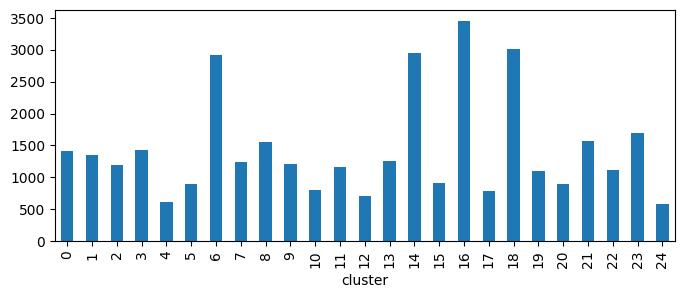

In [41]:
counts = an_df["cluster"].value_counts(sort=False).sort_index()
counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [42]:
def dog_or_cat(text_annotation):
    keywords = ["dog","cat","meow","bark"]
    return any([kw in text_annotation for kw in keywords])

In [133]:
an_df["Dog_Cat"] = an_df["text"].transform(dog_or_cat)
an_df["Dog_Cat"].value_counts()

Dog_Cat
False    33358
True      2468
Name: count, dtype: int64

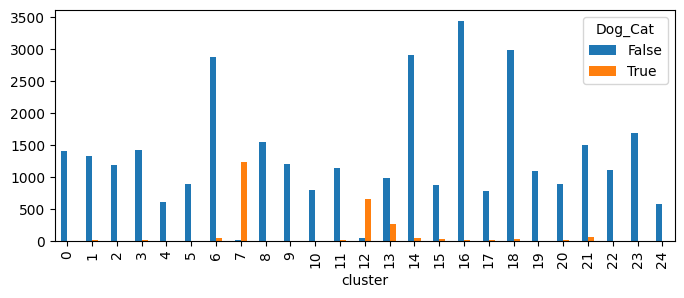

In [44]:
# goup by cluster and bad_weater, get size of eah group and then pivot bad weather from index to column
counts = an_df[["cluster", "Dog_Cat"]].groupby(["cluster", "Dog_Cat"]).size().unstack()

counts.plot(kind="bar", figsize=(8, 3))
plt.show()

In [46]:
an_df[an_df["cluster"]==12]["text"].unique()[:15]

array(['A high pitch meowing coming from a cat',
       "Continuous purrr like sound which resembles to be cat's purring sound.",
       'Low-pitched cat meow with low background noise.',
       'very weak meow of a cat', 'small cat is worried meowing',
       'Cat meowing', 'a cat growl multiple times',
       'A cat miaus briefly and loudly indoors.', 'A cat meowing nearby.',
       'A cat purrs briefly indoors.', 'A cat quietly meowing indoors ',
       'A cat meowing softly indoors',
       'Cat purrs indoors on mid-volume repeatedly.',
       'A soft purr coming from a cat',
       'A high-pitched, gradually increasing, feline meowing, recorded in an indoor setting.'],
      dtype=object)

In [10]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(an_em)

<Axes: xlabel='tsne_dim1', ylabel='tsne_dim2'>

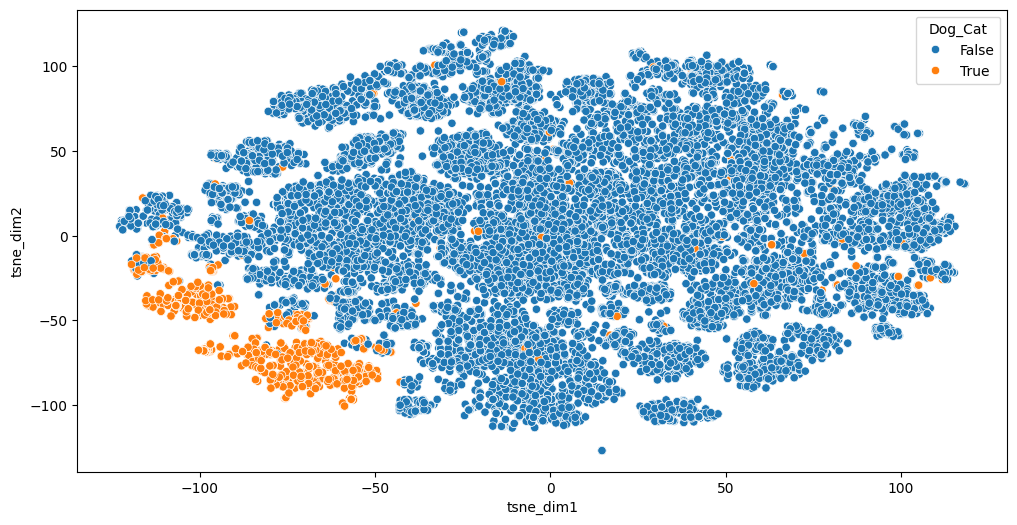

In [31]:
fig,ax = plt.subplots(figsize=(12,6))
an_df["tsne_dim1"] = tsne[:,0]
an_df["tsne_dim2"] = tsne[:,1]
an_df.head()
sns.scatterplot(x=an_df["tsne_dim1"],y=an_df["tsne_dim2"],hue=an_df["Dog_Cat"],ax=ax,legend=True)

**Clustering audio Features**

In [48]:
multi_feature_names= ["melspectrogram","mfcc"]

In [119]:
import numpy as np

mfcc_features = {}

for idx, row in meta_df.iterrows():
    file_name = idx.replace("mp3", "npz")
    path_to_feature_file = os.path.join(r"C:\Users\user\Desktop\MLPC", "audio_features", file_name)
    
    features = np.load(path_to_feature_file)["mfcc"]
    mfcc_features[idx] = features
print("Number of feature files:", len(audio_features))

Number of feature files: 9026


In [117]:
import numpy as np

melspectrogram_features = {}

for idx, row in meta_df.iterrows():
    file_name = idx.replace("mp3", "npz")
    path_to_feature_file = os.path.join(r"C:\Users\user\Desktop\MLPC", "audio_features", file_name)
    
    features = np.load(path_to_feature_file)["melspectrogram"]
    melspectrogram_features[idx] = features
print("Number of feature files:", len(audio_features))

Number of feature files: 9026


In [120]:
import math
from sklearn.preprocessing import StandardScaler
def get_features_of_annotation(
    onset: float, 
    offset: float, 
    audio_features: np.ndarray, 

) -> np.ndarray:
    s= StandardScaler()
    RESOLUTION = 0.12 # temporal resolution of the features is 120 ms
    start_idx = math.floor(onset / RESOLUTION)
    offset_idx = math.ceil(offset / RESOLUTION)
    
    audio_features = audio_features[start_idx:offset_idx, :]
    
    audio_features = s.fit_transform(audio_features)    
    return audio_features.mean(axis=0)
#used code to extract mean mfcc value across all time frames  for each annotated region and ignored the silent regions since they have no corresponding annotations 

In [124]:
X1 = np.zeros((len(an_df), 32))
X2=np.zeros((len(an_df),64))

for i, row in an_df.iterrows():
    X1[i] = get_features_of_annotation(row['onset'], row['offset'], mfcc_features[row['filename']])
for i, row in an_df.iterrows():
    X2[i] = get_features_of_annotation(row['onset'], row['offset'], melspectrogram_features[row['filename']])

    
#used code to create a mfcc feature matrix with the shape of (35826,32) -> each row is a sample (annotated region) and the columns are the mfcc Cosine Transform coefficients. 

In [125]:
kmeans = KMeans(25)
labels= kmeans.fit_predict(X)
# clustered the mfcc feature matrix since now we have a fixed feature vector length (32) for each sample (annotated region) -> since averaged over time 

In [126]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X1_tsne = tsne.fit_transform(X1)
X2_tsne = tsne.fit_transform(X2)
# perform tsne for vis -> since we cant vis a matrix in 2D!!!!



C:\Users\user\anaconda3\envs\computervision\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\user\anaconda3\envs\computervision\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


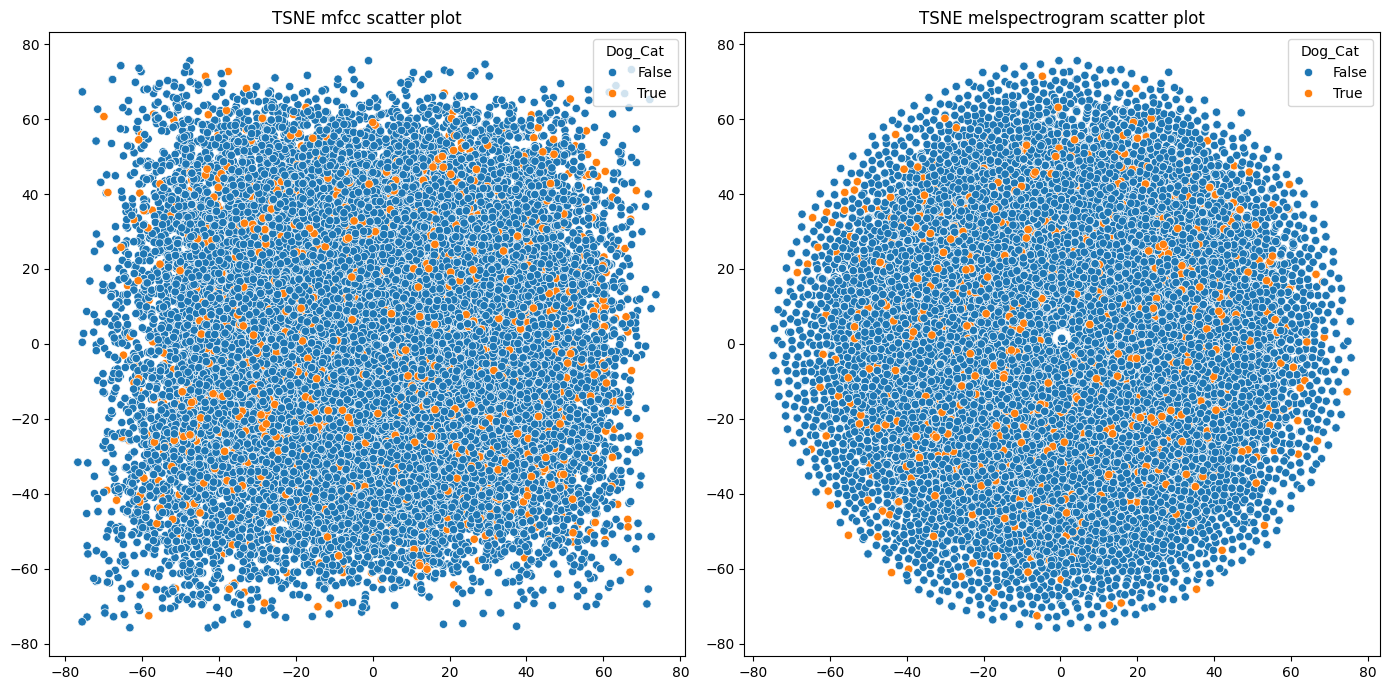

In [139]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
sns.scatterplot(x=X1_tsne[:,0],y=X2_tsne[:,1],hue=an_df["Dog_Cat"],ax=ax[0],legend=True)
sns.scatterplot(x=X2_tsne[:,0],y=X2_tsne[:,1],hue=an_df["Dog_Cat"],ax=ax[1],legend=True)
ax[0].set_title("TSNE mfcc scatter plot")
ax[1].set_title("TSNE melspectrogram scatter plot")
plt.tight_layout()


#assign colors to samples using "dog or cat" column to check if they form tight clusters in the mfcc feature space 

**(c) neither mfcc nor melspectrogram clusters align with text features clusters based on our plots**

In [104]:
#possibly due to the presence of background noise in the annoted regions containing dogs and cats which may affect the audio features in general  

**5**

https://chatgpt.com/share/680962a1-f9d4-8009-a767-6368ae77a866